In [1]:
import cobra
import numpy as np
import matplotlib.pyplot as plt
import graph_utils as gu
from itertools import combinations_with_replacement
import json
from amg_utils import amg_limits, amg_impact_by_parsimony
from plotting_utils import draw_graph

In [2]:
masses = json.loads(open("model_files/masses.json").read())
manual_relabels = json.loads(open("model_files/subsystem_alias.json").read())
amgs = json.loads(open("model_files/amg_reactions.json").read())

In [3]:
model = cobra.io.read_sbml_model("./model_files/ProchlorococcusMED4+PHM2v1.xml")

In [4]:
baseline = amg_impact_by_parsimony(model, amgs, new_amg_penalty=0)

In [5]:
amg_limits_dict = {}
with model as phm2:
    phm2.objective = phm2.reactions.PHM2_prodrxn_VN
    for amg, direction in amgs.items():
        amg_limits_dict[amg] = amg_limits(
            phm2, amg, direction, tol=0.1, optimum_fraction=0.5
        )

FAKEOrthophosphateEX FAKEOrthophosphateEX optimal
FAKEOrthophosphateEX PSIIabs optimal
FAKEOrthophosphateEX R00311 optimal
FAKEOrthophosphateEX R00426 optimal
FAKEOrthophosphateEX R00662 optimal
FAKEOrthophosphateEX R01063 optimal
FAKEOrthophosphateEX R01523 optimal
FAKEOrthophosphateEX R01827 optimal
FAKEOrthophosphateEX R05223 optimal
FAKEOrthophosphateEX R05817 optimal
FAKEOrthophosphateEX R05818 optimal
PSIIabs PSIIabs optimal
PSIIabs R00311 optimal


c:\Users\rozu775\Documents\Code\nwbrave\hm2-amgs-in-med4\.venv\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


PSIIabs R00426 infeasible
PSIIabs R00662 infeasible
PSIIabs R01063 optimal
PSIIabs R01523 optimal
PSIIabs R01827 optimal
PSIIabs R05223 optimal
PSIIabs R05817 optimal
PSIIabs R05818 optimal
R00311 R00311 optimal
R00311 R00426 infeasible
R00311 R00662 infeasible
R00311 R01063 optimal
R00311 R01523 optimal
R00311 R01827 optimal
R00311 R05223 optimal
R00311 R05817 optimal
R00311 R05818 optimal
R00426 R00426 optimal
R00426 R00662 infeasible
R00426 R01063 optimal
R00426 R01523 optimal
R00426 R01827 optimal
R00426 R05223 optimal
R00426 R05817 optimal
R00426 R05818 optimal
R00662 R00662 optimal
R00662 R01063 optimal
R00662 R01523 optimal
R00662 R01827 optimal
R00662 R05223 optimal
R00662 R05817 optimal
R00662 R05818 optimal
R01063 R01063 optimal
R01063 R01523 optimal
R01063 R01827 optimal
R01063 R05223 optimal
R01063 R05817 optimal
R01063 R05818 optimal
R01523 R01523 optimal
R01523 R01827 infeasible
R01523 R05223 optimal
R01523 R05817 optimal
R01523 R05818 optimal
R01827 R01827 optimal
R01827

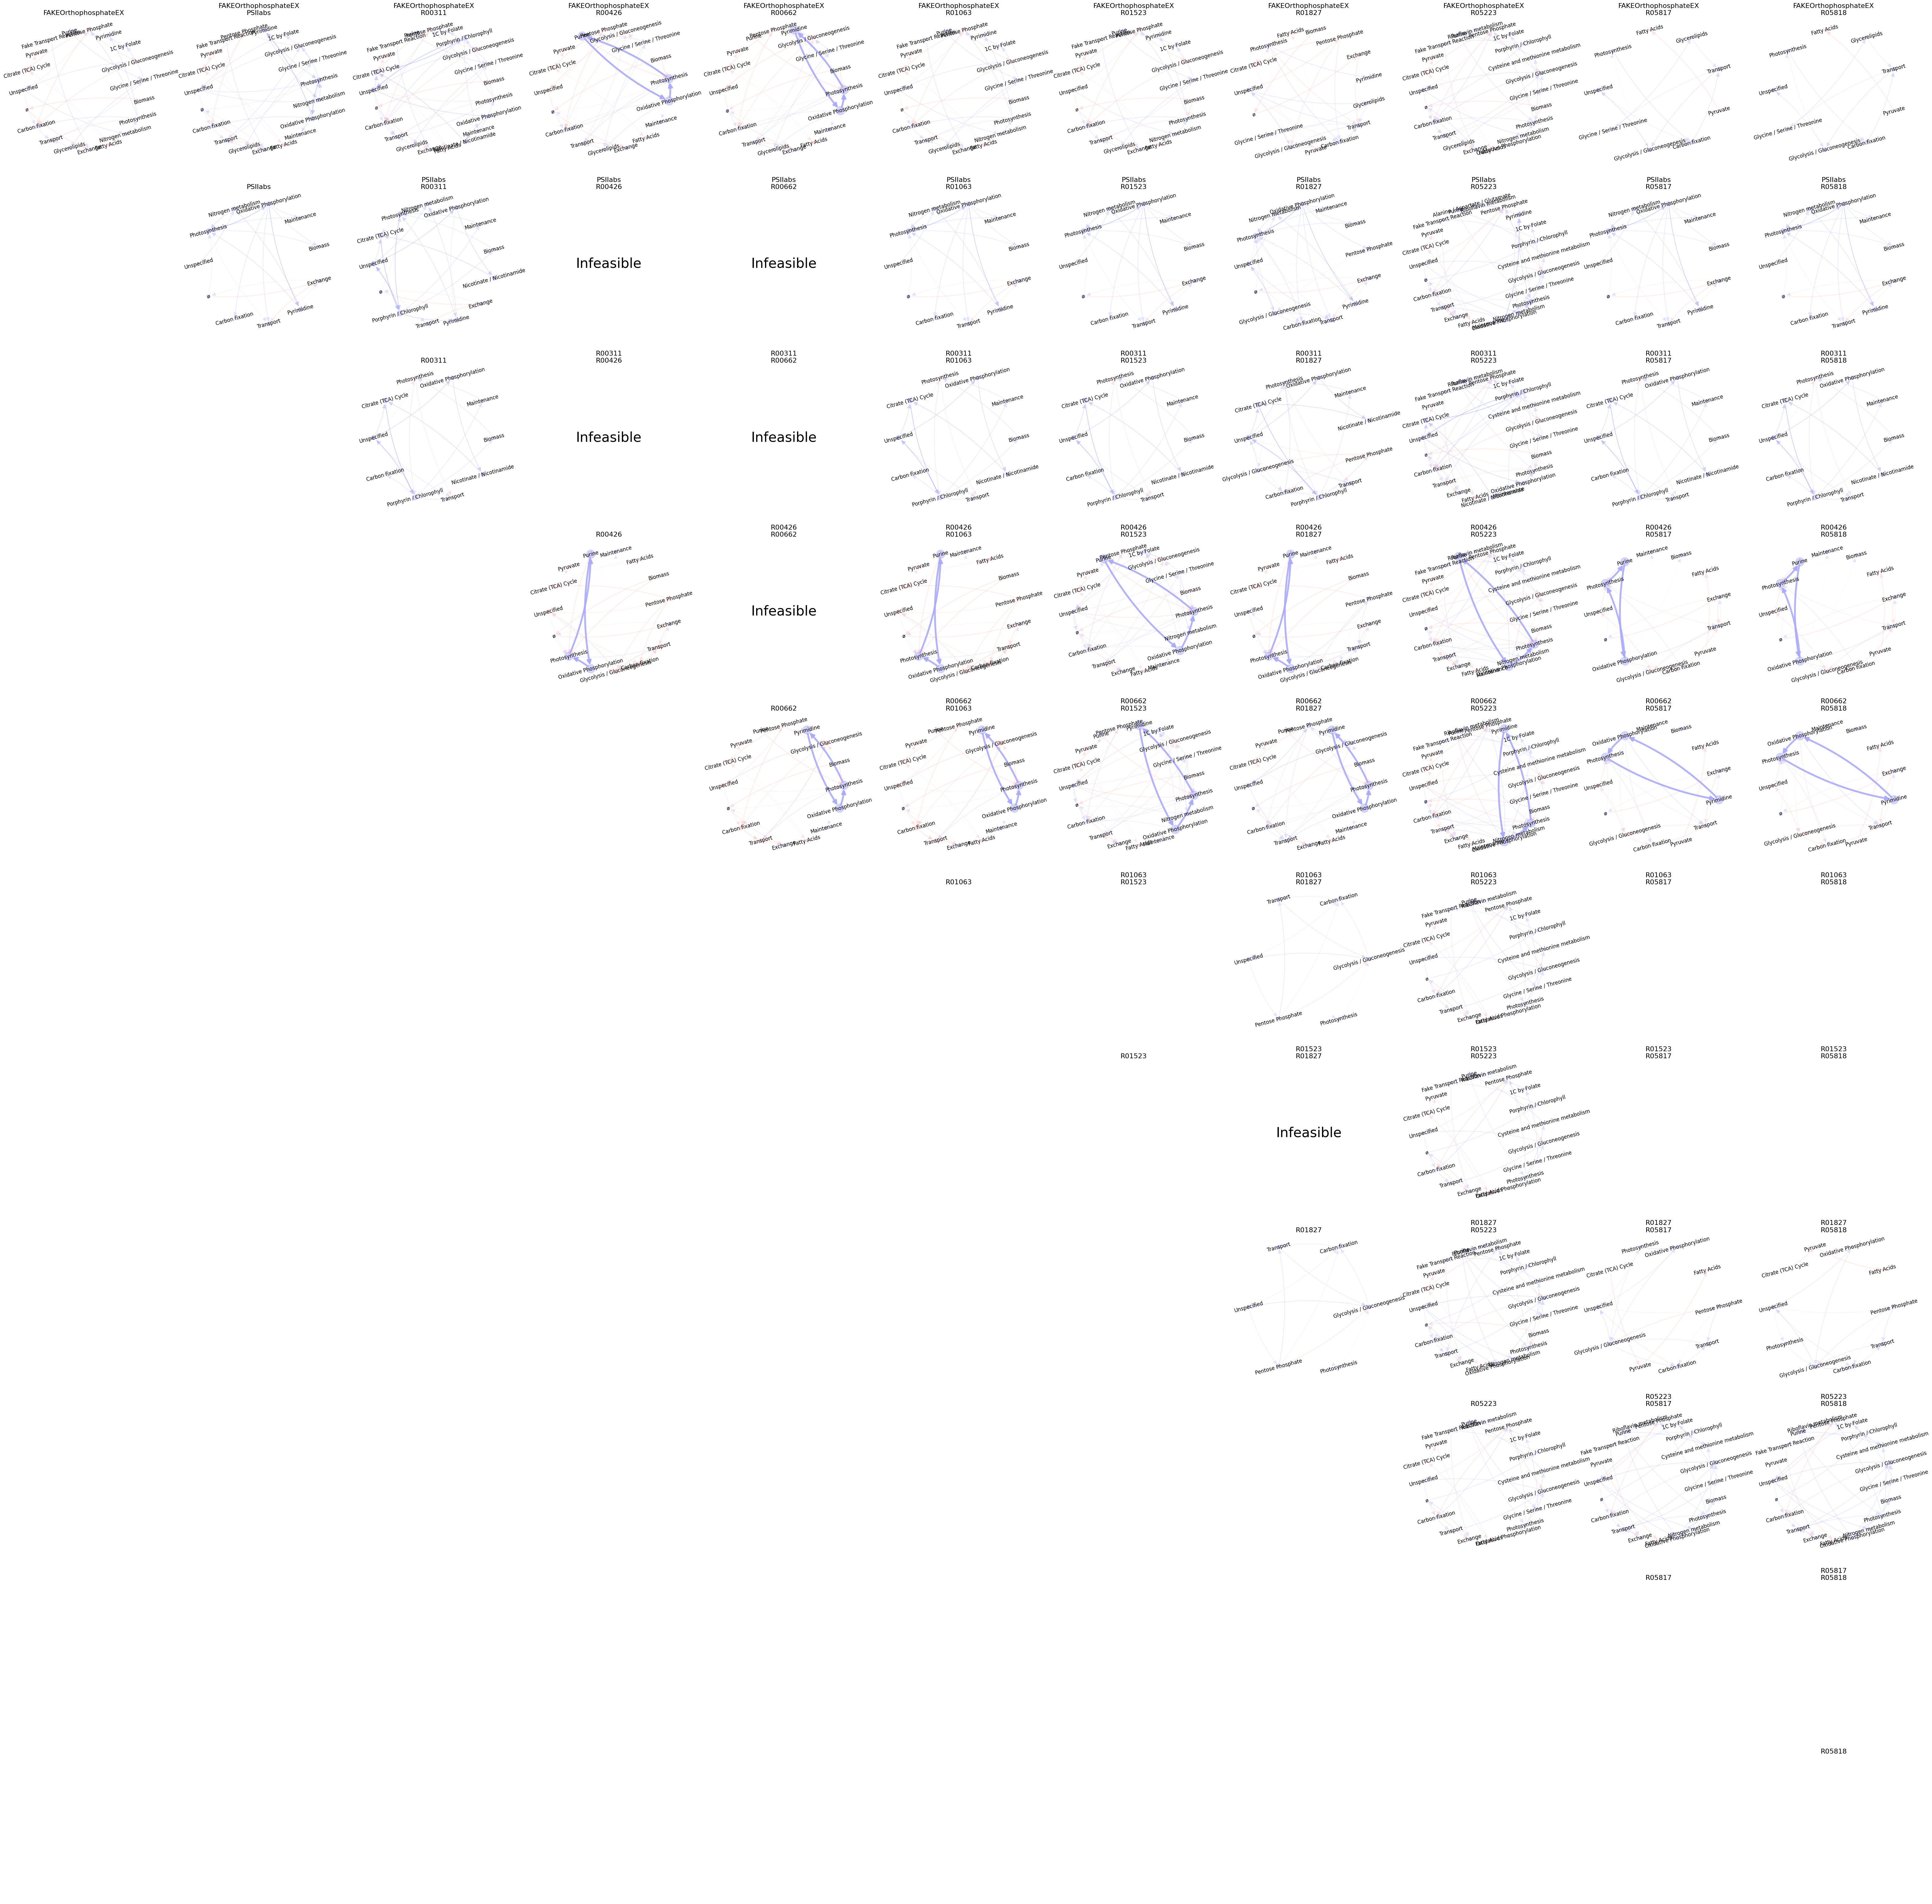

In [6]:
fig, axs = plt.subplots(11, 11, figsize=(80, 80))
graphs = {}
for ax in axs.flatten():
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

for (i, amg1), (j, amg2) in combinations_with_replacement(enumerate(sorted(amgs)), 2):
    with model as smodel:
        ax = axs[i][j]

        smodel.reactions.get_by_id(amg1).bounds = amg_limits_dict[amg1]
        smodel.reactions.get_by_id(amg2).bounds = amg_limits_dict[amg2]
        smoma = cobra.flux_analysis.moma(smodel, baseline)

        ax.xaxis.set_ticks_position("none")
        ax.yaxis.set_ticks_position("none")
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())

        if smoma.status == "optimal":
            go = gu.subsystem_flux_graph(smodel, baseline, masses=masses)
            gp = gu.subsystem_flux_graph(smodel, smoma, masses=masses)
            gd = gu.diff_graph(gp, go)
            graphs[(amg1, amg2)] = (gp, go, gd)
            draw_graph(gd, ax, cut=30 / 300, manual_relabels=manual_relabels, scale=300)
        else:
            ax.annotate(
                "Infeasible",
                xy=(0.5, 0.5),
                xytext=(0.5, 0.5),
                fontsize=32,
                horizontalalignment="center",
                verticalalignment="center",
            )
        if i != j:
            ax.set_title(f"{amg1}\n{amg2}", fontsize=16)
        else:
            ax.set_title(f"{amg1}", fontsize=16)
        print(amg1, amg2, smoma.status)
plt.show()

In [7]:
syn = {}
for (amg1, amg2), (gp, go, gd) in graphs.items():
    if amg1 == amg2:
        continue
    g1 = graphs[(amg1, amg1)][-1]
    g2 = graphs[(amg2, amg2)][-1]
    diff_from_additive = gu.diff_graph(gu.diff_graph(gd, g1), g2)

    msd = np.mean([d["weight"] ** 2 for _, _, d in diff_from_additive.edges(data=True)])
    # msd = np.mean(
    #     [diff_from_additive.in_degree(u) ** 2 for u in diff_from_additive.nodes()]
    # )
    syn[(amg1, amg2)] = msd

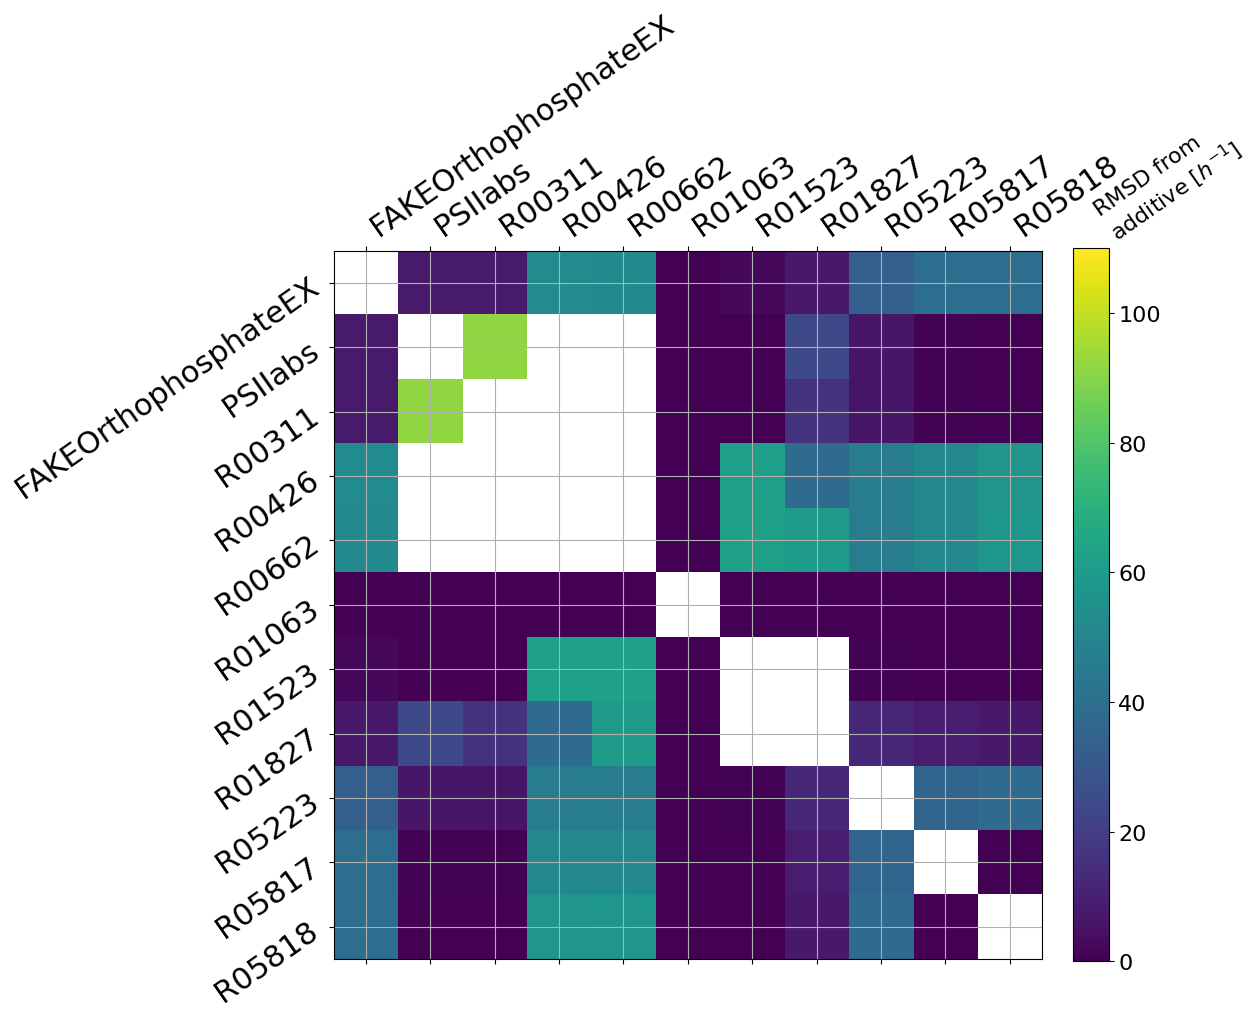

In [34]:
synmat = np.full([11, 11], np.nan)

for (i, amg1), (j, amg2) in combinations_with_replacement(enumerate(sorted(amgs)), 2):
    if (amg1, amg2) in syn:
        synmat[i][j] = syn[(amg1, amg2)]
        synmat[j][i] = syn[(amg1, amg2)]

fig, ax = plt.subplots(figsize=(10, 10))
h = ax.matshow(np.sqrt(synmat), vmin=0, vmax=110)
ax.set_xticks(np.arange(11))
ax.set_yticks(np.arange(11))
ax.set_xticklabels(sorted(amgs), rotation=35, ha="left", fontdict={"fontsize": 22})
ax.set_yticklabels(sorted(amgs), rotation=35, fontdict={"fontsize": 22})
ax.grid(True)
cb = fig.colorbar(h, ax=ax, fraction=0.046, pad=0.04)
cb.ax.set_title(
    "RMSD from\n" + r"additive [$h^{-1}$]",
    rotation=35,
    ha="left",
    fontdict={"fontsize": 16},
)
cb.ax.tick_params(labelsize=16)
plt.show()

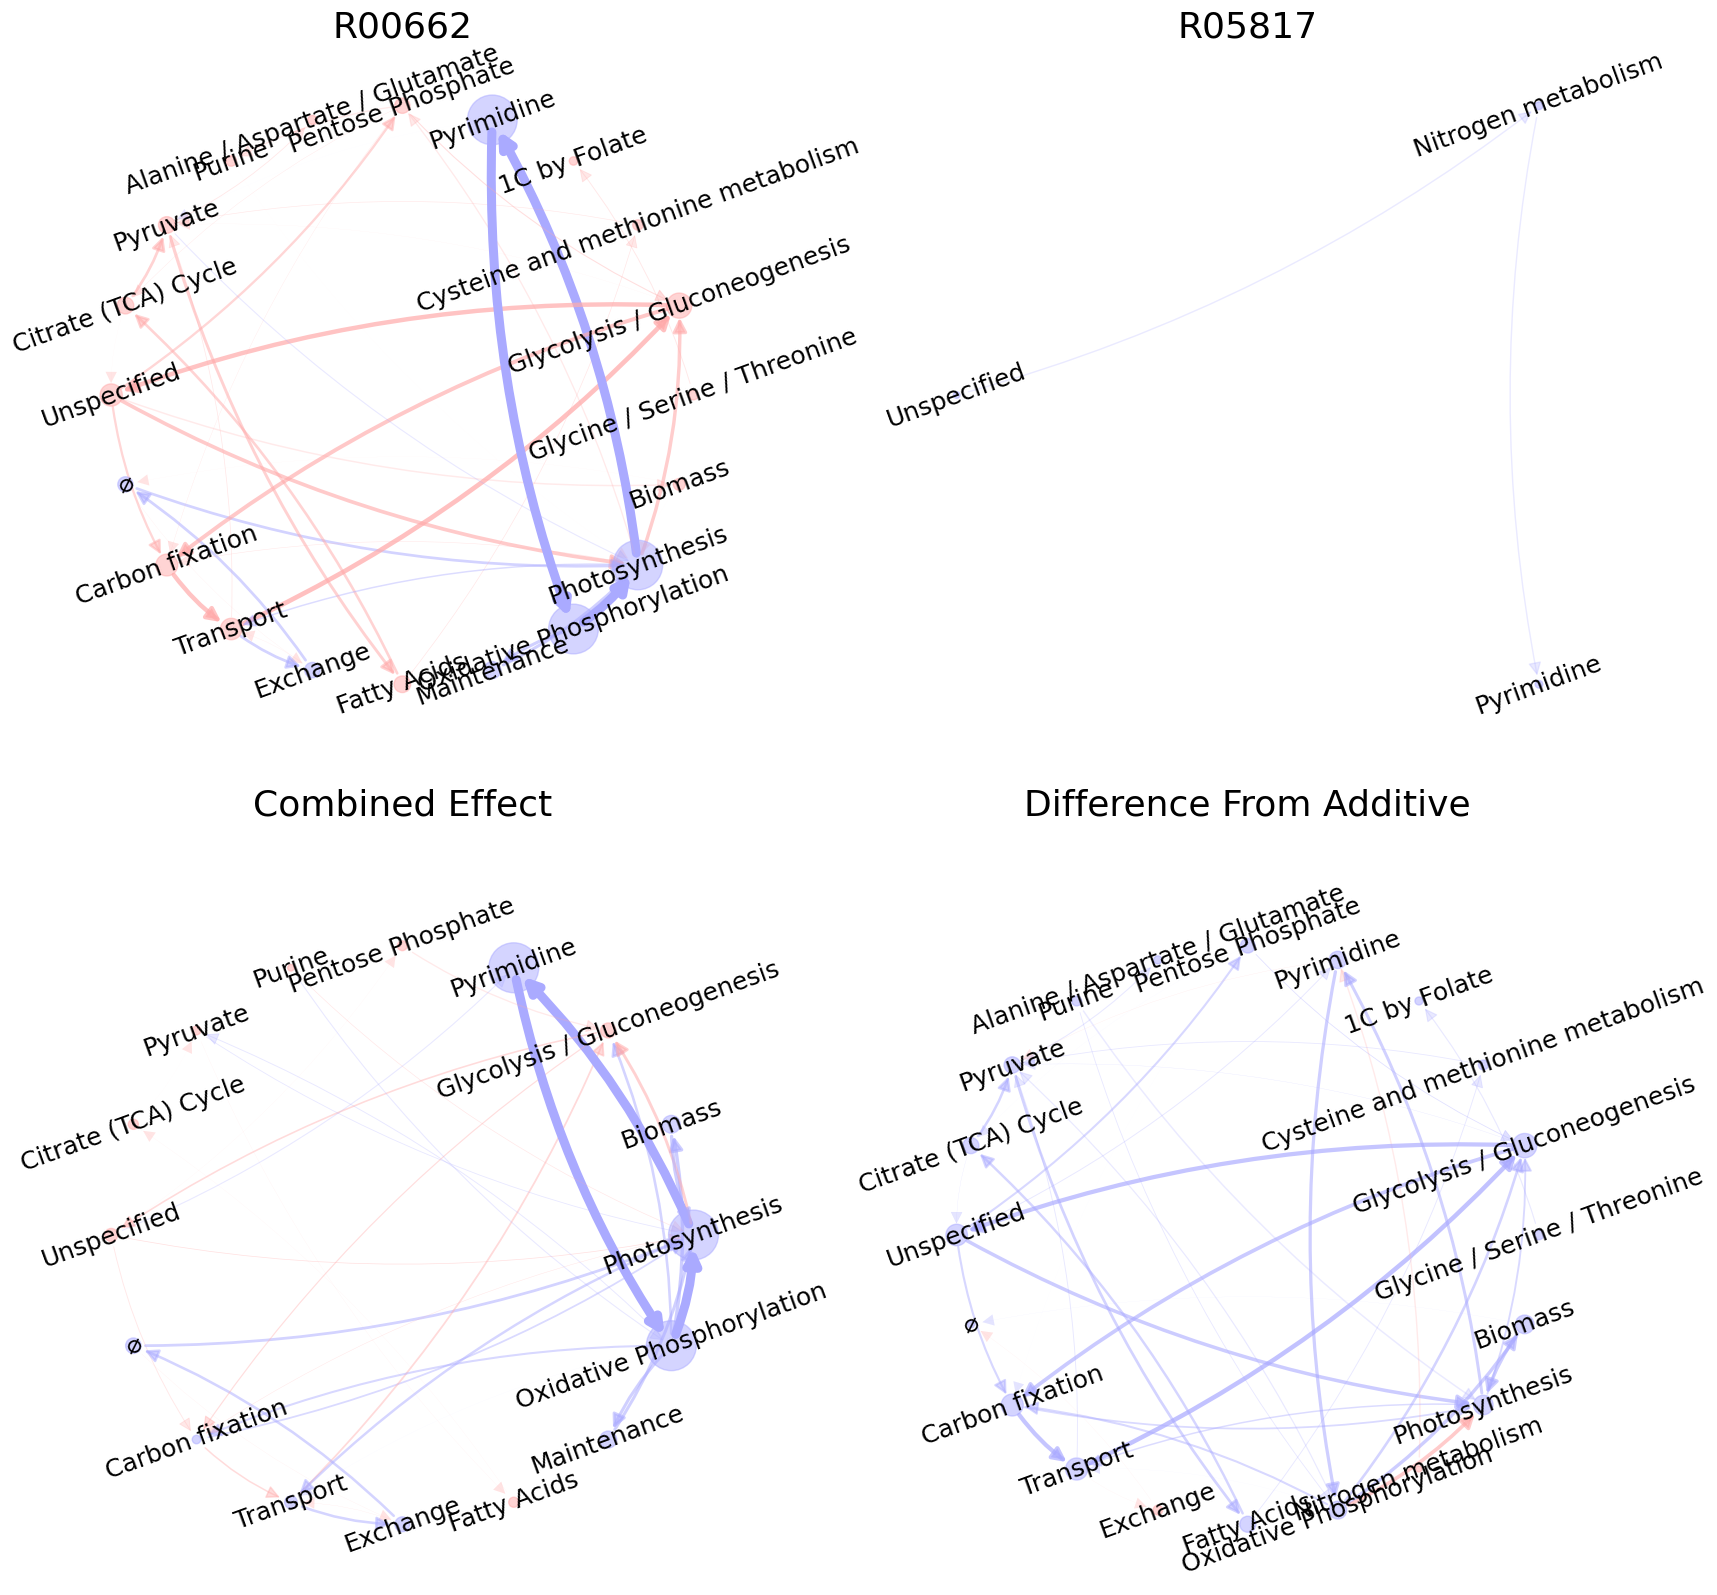

In [56]:
fscale = 10
ncol = 2
nrow = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * fscale, nrow * fscale))

for ax in axs.flatten():
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

order = [
    ((0, "R00662"), (0, "R00662"), "single"),
    ((0, "R05817"), (1, "R05817"), "single"),
    ((1, "R00662"), (0, "R05817"), "combo"),
    ((1, "R00662"), (1, "R05817"), "diff"),
]

for (i, amg1), (j, amg2), combo in order:
    ax = axs[i][j]

    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    if (amg1, amg2) in graphs:
        (gp, go, gd) = graphs[(amg1, amg2)]
        scale = 30
        if combo != "diff":
            gd2 = gd
        else:
            g1 = graphs[(amg1, amg1)][-1]
            g2 = graphs[(amg2, amg2)][-1]
            gd2 = gu.diff_graph(gu.diff_graph(gd, g1), g2)
        draw_graph(
            gd2,
            ax,
            cut=10 / scale,
            manual_relabels=manual_relabels,
            scale=scale,
            label_rotation=20,
        )
    else:
        ax.annotate(
            "Infeasible",
            xy=(0.5, 0.5),
            xytext=(0.5, 0.5),
            fontsize=32,
            horizontalalignment="center",
            verticalalignment="center",
        )
    for t in ax.get_children():
        if isinstance(t, plt.Text):
            t.set_fontsize(18)

    tfs = 26
    if combo == "single":
        ax.set_title(f"{amg1}", fontsize=tfs)
    elif combo == "combo":
        ax.set_title("Combined Effect", fontsize=tfs, pad=50)
    elif combo == "diff":
        ax.set_title("Difference From Additive", fontsize=tfs, pad=50)
    else:
        raise ValueError(f"Unknown combination type {combo}")

plt.show()

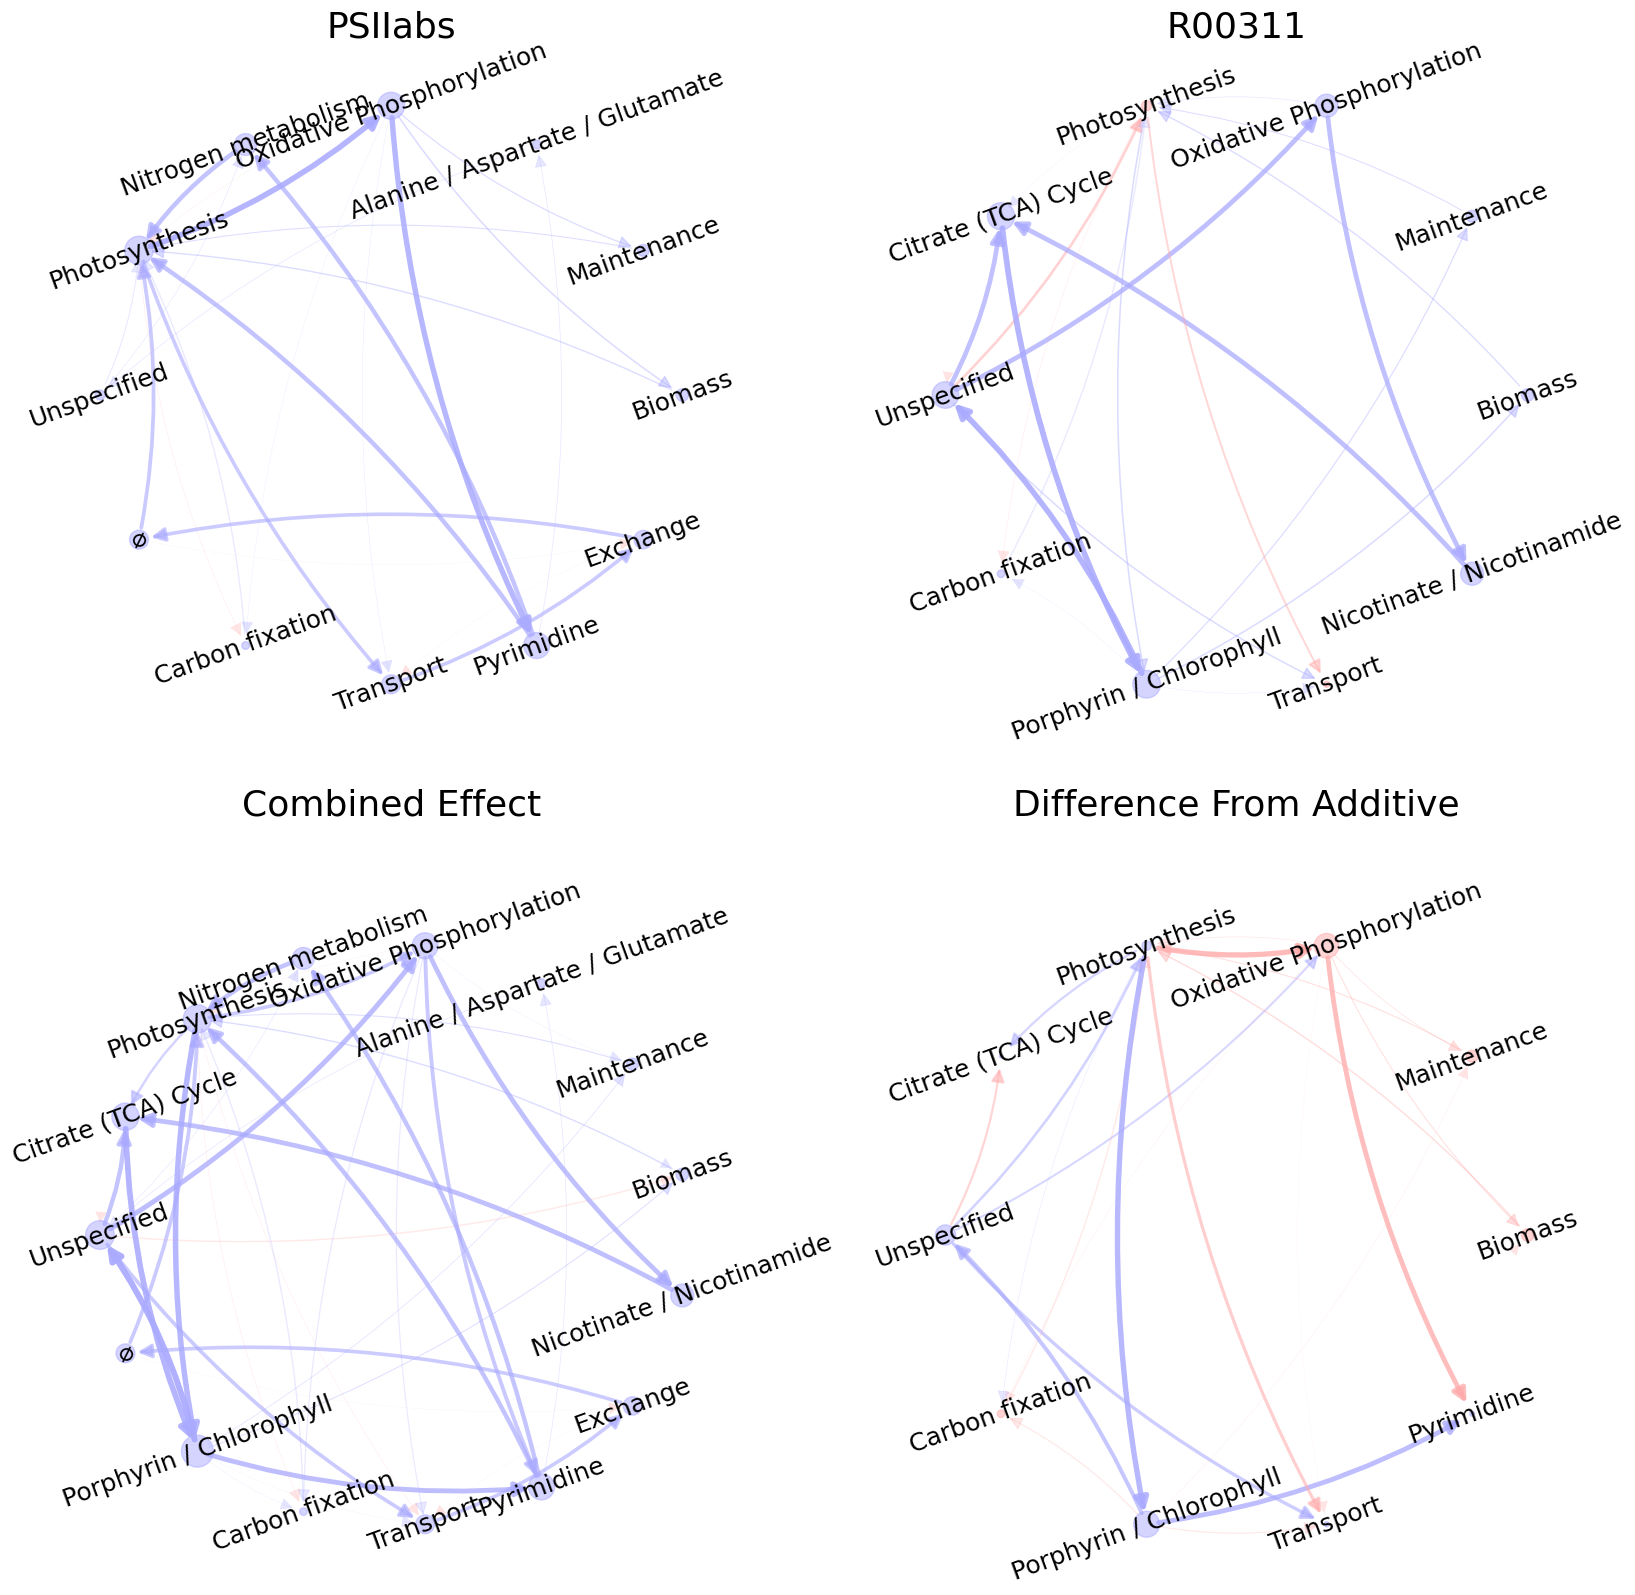

In [55]:
fscale = 10
ncol = 2
nrow = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * fscale, nrow * fscale))

for ax in axs.flatten():
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

order = [
    ((0, "PSIIabs"), (0, "PSIIabs"), "single"),
    ((0, "R00311"), (1, "R00311"), "single"),
    ((1, "PSIIabs"), (0, "R00311"), "combo"),
    ((1, "PSIIabs"), (1, "R00311"), "diff"),
]

for (i, amg1), (j, amg2), combo in order:
    ax = axs[i][j]

    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    if (amg1, amg2) in graphs:
        (gp, go, gd) = graphs[(amg1, amg2)]
        scale = 30
        if combo != "diff":
            gd2 = gd
        else:
            g1 = graphs[(amg1, amg1)][-1]
            g2 = graphs[(amg2, amg2)][-1]
            gd2 = gu.diff_graph(gu.diff_graph(gd, g1), g2)
        draw_graph(
            gd2,
            ax,
            cut=10 / scale,
            manual_relabels=manual_relabels,
            scale=scale,
            label_rotation=20,
        )
    else:
        ax.annotate(
            "Infeasible",
            xy=(0.5, 0.5),
            xytext=(0.5, 0.5),
            fontsize=32,
            horizontalalignment="center",
            verticalalignment="center",
        )
    for t in ax.get_children():
        if isinstance(t, plt.Text):
            t.set_fontsize(18)

    tfs = 26
    if combo == "single":
        ax.set_title(f"{amg1}", fontsize=tfs)
    elif combo == "combo":
        ax.set_title("Combined Effect", fontsize=tfs, pad=50)
    elif combo == "diff":
        ax.set_title("Difference From Additive", fontsize=tfs, pad=50)
    else:
        raise ValueError(f"Unknown combination type {combo}")

plt.show()